In [1]:

# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# CLustering 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fowlkes_mallows_score
#Optimization
import optuna
# Output control
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
# Json
import json

In [2]:
adata = sc.read("datasets/tumour_cellcounts.h5ad")
padata = sc.read("datasets/processed_pooledcounts.h5ad")

# **Gene set variation analysis for aggresive cancer gene-sets**

First of all we need to find the corresponding gene sets for the EMT, ANGIOGENESIS and STEMNESS pathways. We can discover these from the relevant SOURCES by  [Hallmark](https://pubmed.ncbi.nlm.nih.gov/26771021/), [Lawson et al.](https://www.nature.com/articles/nature15260)

In [3]:
with open('Genesets/HALLMARK_ANGIOGENESIS.v2023.1.Hs.json', 'r') as file:
    angiogenesis_gene_set = json.load(file)
    angiogenesis_gene_set = angiogenesis_gene_set['HALLMARK_ANGIOGENESIS']['geneSymbols']
    
with open('Genesets/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.v2023.1.Hs.json', 'r') as file:
    emt_gene_set = json.load(file)
    emt_gene_set = emt_gene_set['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']['geneSymbols']
    
with open('Genesets/LAWSON_STEMNESS.json','r') as file:
    stemness_gene_set = json.load(file)
    stemness_gene_set = stemness_gene_set['geneSymbols']

Due to preprocessing some genes are not available in the current dataset form, so we take the intersection of the gene sets with our dataset and report the number of genes removed with this method.

In [4]:
angiogenesis_gene_set_final = set(adata.var_names) & set(angiogenesis_gene_set)
print(f"Genes removed from the gene set: {len(set(angiogenesis_gene_set) - angiogenesis_gene_set_final)} out of {len(angiogenesis_gene_set)}\n")

emt_gene_set_final = set(adata.var_names) & set(emt_gene_set)
print(f"Genes removed from the gene set: {len(set(emt_gene_set) - emt_gene_set_final)} out of {len(emt_gene_set)}\n")

stemness_gene_set_final = set(adata.var_names) & set(stemness_gene_set)
print(f"Genes removed from the gene set: {len(set(stemness_gene_set) - stemness_gene_set_final)} out of {len(stemness_gene_set)}\n")

Genes removed from the gene set: 4 out of 36

Genes removed from the gene set: 8 out of 200

Genes removed from the gene set: 0 out of 34



In [5]:
sc.tl.score_genes(adata,angiogenesis_gene_set_final,score_name = "Angiogenesis score")
sc.tl.score_genes(adata,emt_gene_set_final,score_name = "EMT score")
sc.tl.score_genes(adata,stemness_gene_set_final,score_name = "Stemness score")

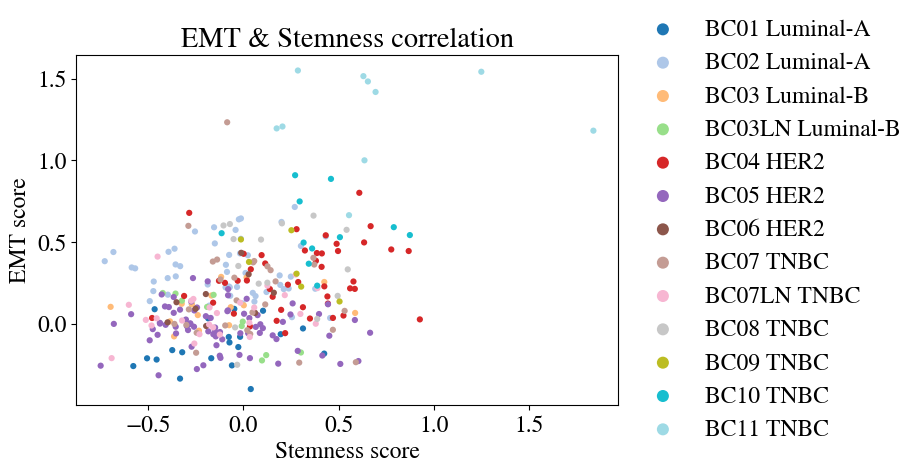

In [6]:
sc.pl.scatter(adata, x = 'Stemness score', y = "EMT score", color='tumor_groups', size = 80,title="EMT & Stemness correlation")

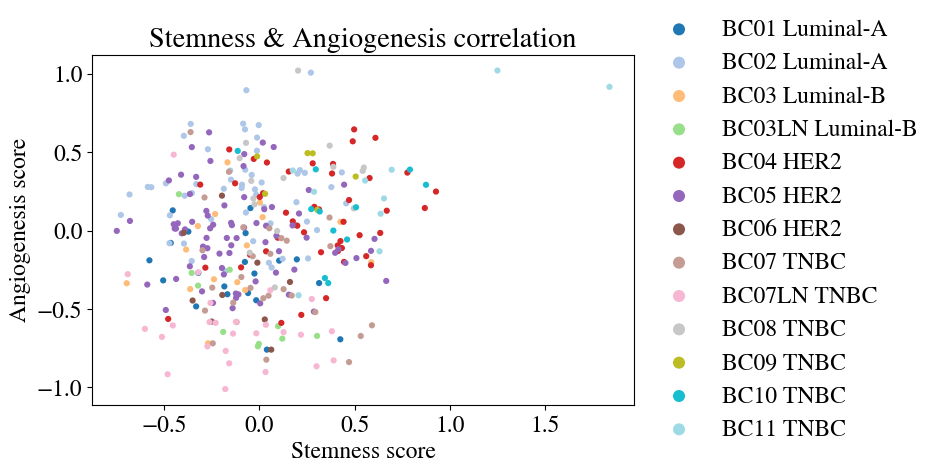

In [7]:
sc.pl.scatter(adata, x = 'Stemness score', y = "Angiogenesis score", color='tumor_groups', size = 80,title="Stemness & Angiogenesis correlation")

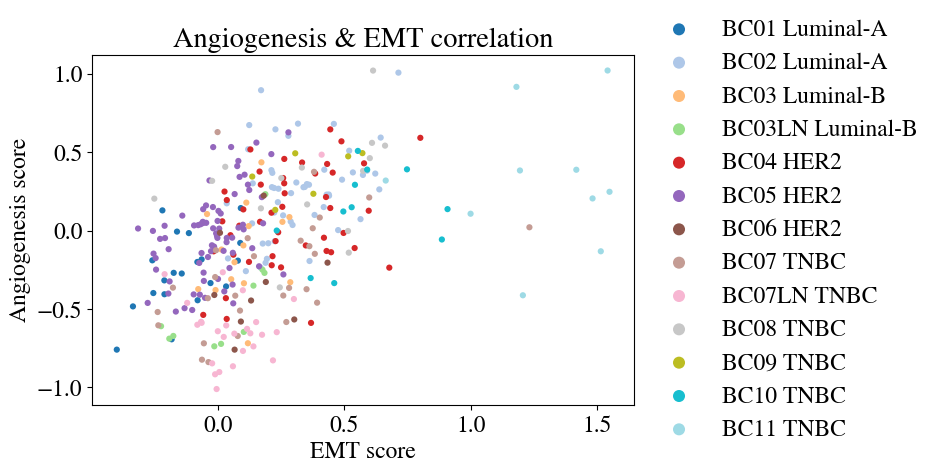

In [8]:
sc.pl.scatter(adata, x = "EMT score",y = 'Angiogenesis score', color='tumor_groups', size = 80,title="Angiogenesis & EMT correlation")


Triple-negative breast cancer (TNBC) cells exhibit relatively elevated epithelial-mesenchymal transition (EMT) signatures, while both HER2 and TNBC tumor cells display increased levels of stemness and angiogenesis signatures. However, it is crucial to acknowledge the heterogeneity present within cancer subtypes.

# **GSVA for Subtype-specific gene expression profiling at single-cell resolution.**

The merker genes for ER+, HER2+ and TNBC cancer subtypes are given to us in pdf format from the original paper, so we scrape them and load them into json files

In [9]:
with open('Genesets/ERPLUSMARKERS.json', 'r') as file:
    er_marker_genes = json.load(file)
    er_marker_genes = er_marker_genes['genes']
    
with open('Genesets/HER2PLUSMARKERS.json', 'r') as file:
    her2_marker_genes = json.load(file)
    her2_marker_genes = her2_marker_genes['genes']
    
with open('Genesets/TNBCMARKERS.json','r') as file:
    tnbc_marker_genes = json.load(file)
    tnbc_marker_genes = tnbc_marker_genes['genes']

**HER2 positive marker genes**

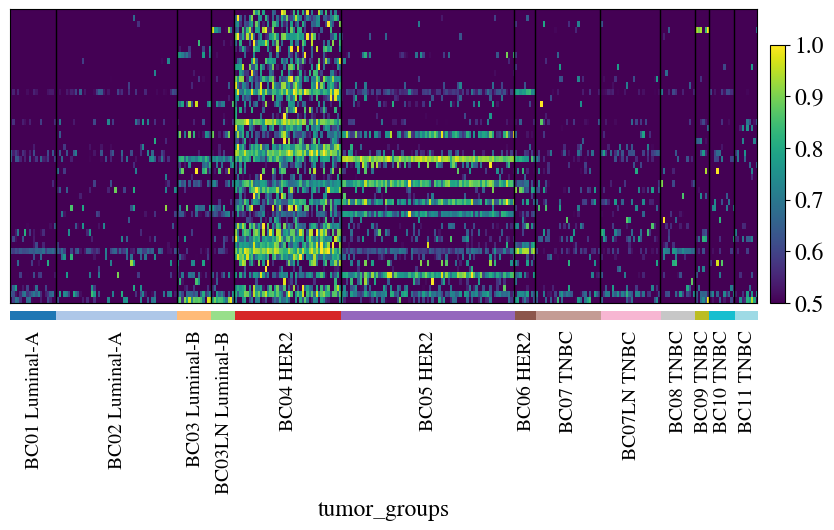

In [51]:
sc.pl.heatmap(adata, var_names =her2_marker_genes, groupby = "tumor_groups",swap_axes=True,show_gene_labels=False,standard_scale ='var',vmin = 0.5)

**TNBC positive marker genes**

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: xlabel='tumor_groups'>}

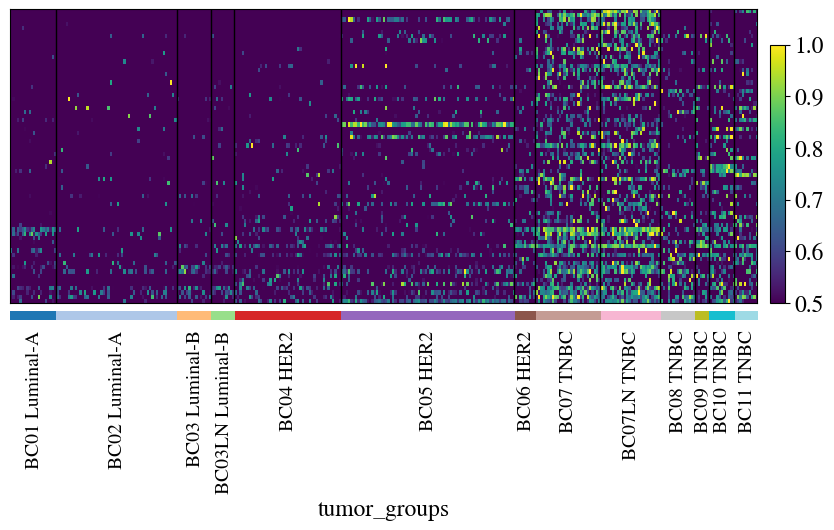

In [57]:
sc.pl.heatmap(adata, var_names =tnbc_marker_genes, groupby = "tumor_groups",swap_axes=True,standard_scale='var',vmin = 0.5,show=False)

**ER positive marker genes**

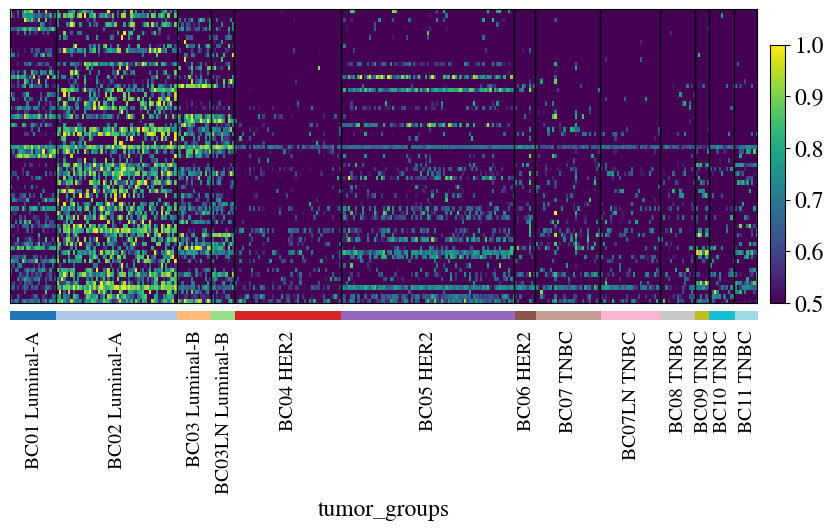

In [47]:
sc.pl.heatmap(adata, var_names =er_marker_genes, groupby = "tumor_groups",swap_axes=True,standard_scale='var',vmin = 0.5)

**Combined marker gene analysis**

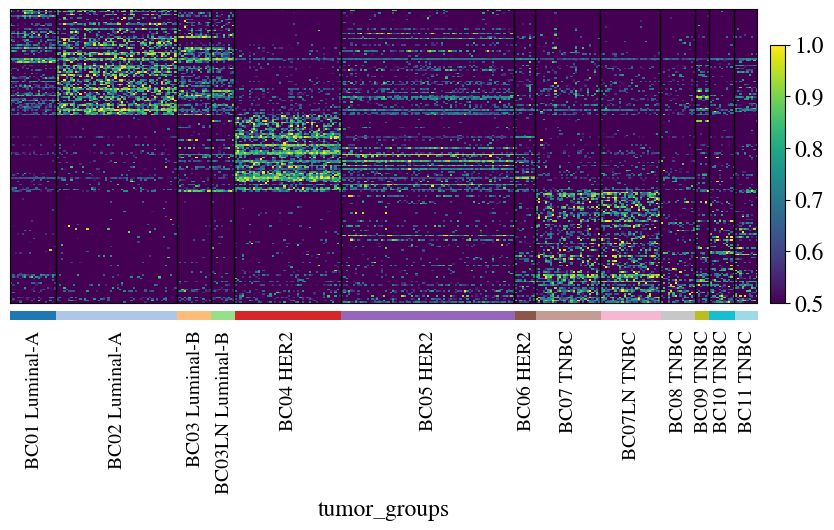

In [59]:
sc.pl.heatmap(adata, 
              var_names =er_marker_genes + her2_marker_genes + tnbc_marker_genes,
              groupby = "tumor_groups",
              swap_axes=True,
              standard_scale = 'var',
              vmin = 0.50,
              var_group_labels=['ER', 'HER2', 'TNBC']
              )

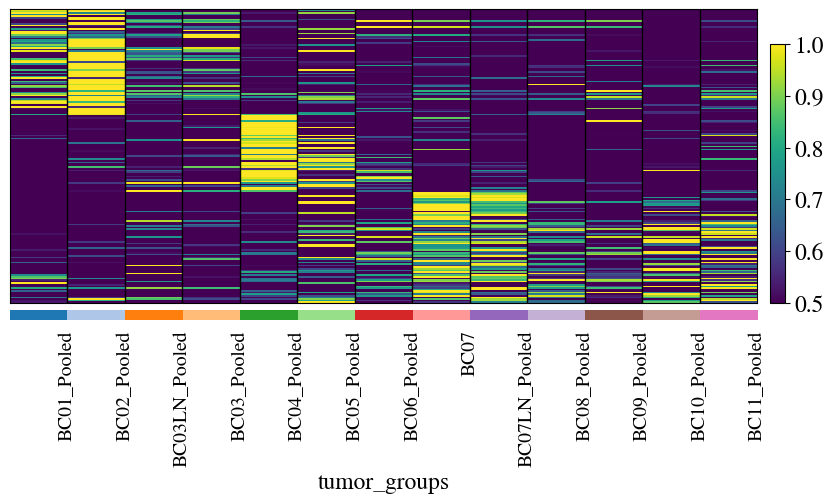

In [52]:
sc.pl.heatmap(padata,
              var_names =er_marker_genes + her2_marker_genes + tnbc_marker_genes,
              groupby='tumor_groups',
              swap_axes=True,
              standard_scale = "var",
              vmin=0.5
              )